<a href="https://colab.research.google.com/github/uncertainity/Variational-Auto-Encoder/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D, 
                                     UpSampling2D, BatchNormalization)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_image(filepath):
  raw_img = tf.io.read_file(filepath)
  img_tensor_int = tf.image.decode_jpeg(raw_img,channels = 3)
  img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int,dtype = tf.float32)
  return img_tensor_flt,img_tensor_flt

def load_dataset(split):
  train_list_ds = tf.data.Dataset.list_files("/content/drive/MyDrive/CelebA subset/{}/*.jpg".format(split),shuffle = False)
  train_ds = train_list_ds.map(load_image)
  return train_ds

In [4]:
train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

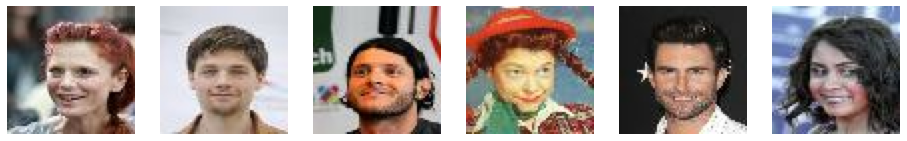

In [5]:
n_examples = 6
f,axs = plt.subplots(1,n_examples,figsize = (16,3))
for j,image in enumerate(train_ds.take(n_examples)):
  axs[j].imshow(image[0])
  axs[j].axis("off")


In [6]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

P(z) ----> The prior (taken as mixture of gaussian)

q(z|x) ----> The approximate dist is taken as multivariate normal

In [7]:
def get_prior(num_modes,latent_dim):
  prior = tfd.MixtureSameFamily(mixture_distribution = tfd.Categorical(probs = tf.divide(tf.ones([num_modes,]),num_modes)),
                                components_distribution = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.random.normal([num_modes,latent_dim]),trainable = True,dtype = tf.float32),
                                                                                  scale_diag = tfp.util.TransformedVariable(initial_value = tf.ones([num_modes,latent_dim]),
                                                                                  bijector = tfb.Softplus())))
  return prior

In [8]:
prior = get_prior(num_modes = 2,latent_dim = 50)
print(prior)

tfp.distributions.MixtureSameFamily("MixtureSameFamily", batch_shape=[], event_shape=[50], dtype=float32)


In [9]:
prior.sample(5)

<tf.Tensor: shape=(5, 50), dtype=float32, numpy=
array([[-5.94262123e-01,  2.45196998e-01, -6.69222891e-01,
         1.65956211e+00,  3.23167419e+00,  1.36109352e+00,
        -1.71703744e+00,  4.07104671e-01, -5.47844350e-01,
         1.23185110e+00, -1.45208299e+00, -3.81526977e-01,
        -1.96950483e+00, -2.94166088e-01, -1.56044769e+00,
         1.76972592e+00, -9.06025410e-01, -3.69927399e-02,
        -8.68433714e-03,  4.57694456e-02,  5.41405678e-02,
        -2.78110361e+00, -2.82654691e+00,  1.99305809e+00,
         1.00712037e+00,  5.41301429e-01,  1.88056815e+00,
         1.10856223e+00, -2.82162237e+00,  1.10491562e+00,
         1.60357982e-01,  8.86577070e-01,  7.87157714e-02,
        -6.70323312e-01, -1.17265320e+00,  1.14511263e+00,
         2.40174985e+00, -1.85471416e+00,  8.30856621e-01,
        -1.29362488e+00, -1.12648535e+00,  1.36276126e+00,
        -1.02523565e-02, -2.78127956e+00,  1.43925154e+00,
         1.51621312e-01, -3.29809546e-01, -1.25054359e-01,
       

In [10]:
## defining the KL divergecne regularizer
def get_kl_regularizer(prior):
  return tfpl.KLDivergenceRegularizer(distribution_b=prior,use_exact_kl = False,weight = 1.0, test_points_fn = lambda q:q.sample(3),test_points_reduce_axis=(0,1))
  

In [11]:
kl_regularizer = get_kl_regularizer(prior)
kl_regularizer

In [12]:
def get_encoder(latent_dim,kl_regularizer):
  model = Sequential([
                      Conv2D(filters = 32,kernel_size = (4,4),strides = (2,2),padding = "same",activation = "relu",input_shape = (64,64,3)),
                      BatchNormalization(),
                      Conv2D(filters = 64,kernel_size = (4,4),strides = (2,2),padding = "same",activation = "relu"),
                      BatchNormalization(),
                      Conv2D(filters = 128,kernel_size = (4,4),strides = (2,2),padding = "same",activation = "relu"),
                      BatchNormalization(),
                      Conv2D(filters = 256,kernel_size = (4,4),strides = (2,2),padding = "same",activation = "relu"),
                      BatchNormalization(),
                      Flatten(),
                      Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
                      tfpl.MultivariateNormalTriL(activity_regularizer = kl_regularizer,event_size = latent_dim)
  ])
  return model

In [13]:
encoder = get_encoder(latent_dim = 50,kl_regularizer = kl_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 128)        5

In [14]:
def get_decoder(latent_dim):
  
    model = Sequential([
                        Dense(units=4096, activation="relu", input_shape=(latent_dim,)),
                        Reshape(target_shape=(4, 4, 256)),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="SAME"),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="SAME"),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="SAME"),
                        UpSampling2D(size=(2,2)),
                        Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="SAME"),
                        Conv2D(filters=3, kernel_size=(3,3), padding="SAME"),
                        Flatten(),
                        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    
    return model

In [15]:
decoder = get_decoder(latent_dim=50)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              208896    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [16]:
vae = Model(inputs = encoder.inputs,outputs = decoder(encoder.outputs))

In [17]:
def reconstruction_loss(batch_of_images,decoding_dist):
  return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images))

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [19]:
history = vae.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
313/313 [==============================] - 295s 890ms/step - loss: 7141.6846 - val_loss: 6980.1030
Epoch 2/20
313/313 [==============================] - 10s 30ms/step - loss: 6726.3047 - val_loss: 6633.6157
Epoch 3/20
313/313 [==============================] - 10s 31ms/step - loss: 6598.5220 - val_loss: 6577.5825
Epoch 4/20
313/313 [==============================] - 10s 30ms/step - loss: 6520.6328 - val_loss: 6501.1841
Epoch 5/20
313/313 [==============================] - 10s 31ms/step - loss: 6470.1670 - val_loss: 6452.2993
Epoch 6/20
313/313 [==============================] - 10s 31ms/step - loss: 6427.9346 - val_loss: 6422.3193
Epoch 7/20
313/313 [==============================] - 10s 31ms/step - loss: 6397.9771 - val_loss: 6394.1929
Epoch 8/20
313/313 [==============================] - 10s 31ms/step - loss: 6372.5674 - val_loss: 6380.0391
Epoch 9/20
313/313 [==============================] - 10s 31ms/step - loss: 6346.5391 - val_loss: 6354.3750
Epoch 10/20
313/313 [=====

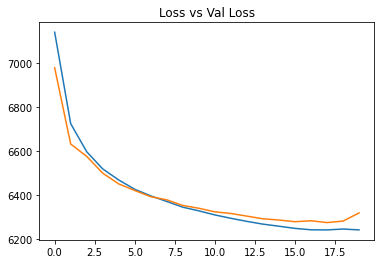

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs Val Loss")
plt.show()


In [21]:
test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

32/32 [==============================] - 117s 4s/step - loss: 6247.8838
Test loss: 6247.8837890625


In [22]:
def reconstruct(encoder,decoder,batch_of_images):
  return decoder(encoder(batch_of_images).mean()).mean()


In [23]:
n_examples = 6
test_images = next(iter(test_ds))[0].numpy()
test_images = test_images[:n_examples]
reconstructions = reconstruct(encoder,decoder,test_images)


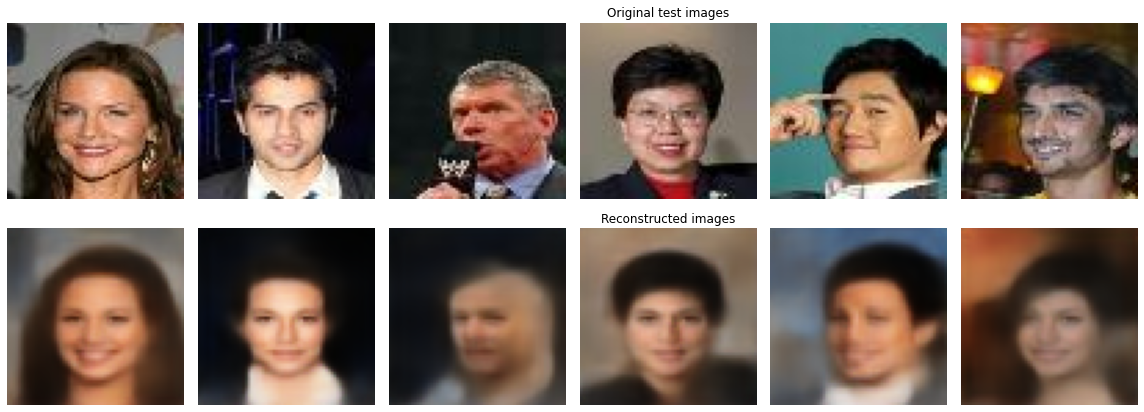

In [24]:
n_reconstructions = 6
f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")
for j in range(n_reconstructions):
    axs[0, j].imshow(test_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();

In [25]:
def generate_images(prior,decoder,n_samples):
  embeddings = prior.sample(n_samples)
  return decoder(embeddings).mean().numpy()

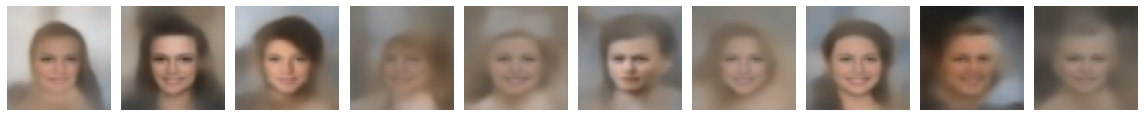

In [26]:
n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
    
plt.tight_layout();

In [27]:
def load_labels_and_image_arrays(split):
    dataset = load_dataset(split)
    files = [f for f in os.listdir("/content/drive/MyDrive/CelebA subset/{}/".format(split)) if f.endswith('.jpg')]
    
    for all_images, _ in dataset.batch(len(files)).take(1):
        all_images_np = all_images.numpy()

    labels = pd.read_csv("/content/drive/MyDrive/CelebA subset/list_attr_celeba_subset.csv")
    labels = labels[labels['image_id'].isin(files)]
    return labels, all_images_np

In [28]:
train_labels, training_subset = load_labels_and_image_arrays('train')

In [29]:
training_subset.shape

(10000, 64, 64, 3)

In [30]:
train_labels.columns[2:]

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [31]:
attribute = "Smiling"
attribute_mask = (train_labels[attribute] == 1)
images_with_attribute = training_subset[attribute_mask]
not_attribute_mask = (train_labels[attribute] == -1)
images_without_attribute = training_subset[not_attribute_mask]

In [32]:
encoded_images_with_attribute = encoder(images_with_attribute)
encoded_images_without_attribute = encoder(images_without_attribute)

In [33]:
mean_encoded_images_with_attribute = tf.reduce_mean(encoded_images_with_attribute.mean(), 
                                                    axis=0, keepdims=True)
mean_encoded_images_without_attribute = tf.reduce_mean(encoded_images_without_attribute.mean(), 
                                                    axis=0, keepdims=True)

In [34]:
attribute_vector = mean_encoded_images_with_attribute -  mean_encoded_images_without_attribute

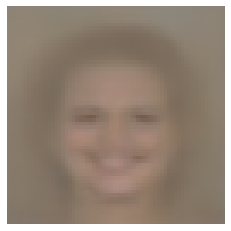

In [35]:
decoded_a = decoder(attribute_vector).mean()
plt.imshow(decoded_a.numpy().squeeze())
plt.axis('off');

In [36]:
n_examples = 7
sampled_inx = np.random.choice(images_without_attribute.shape[0], n_examples, replace=False)
sample_images_without_attribute = images_without_attribute[sampled_inx]
sample_images_encodings = encoder(sample_images_without_attribute)
sample_images_reconstructions = decoder(sample_images_encodings).mean()

k = 2.5  # Weighting of attribute vector
modified_sample_images_encodings = sample_images_encodings + (k * attribute_vector)
modified_reconstructions = decoder(modified_sample_images_encodings).mean()

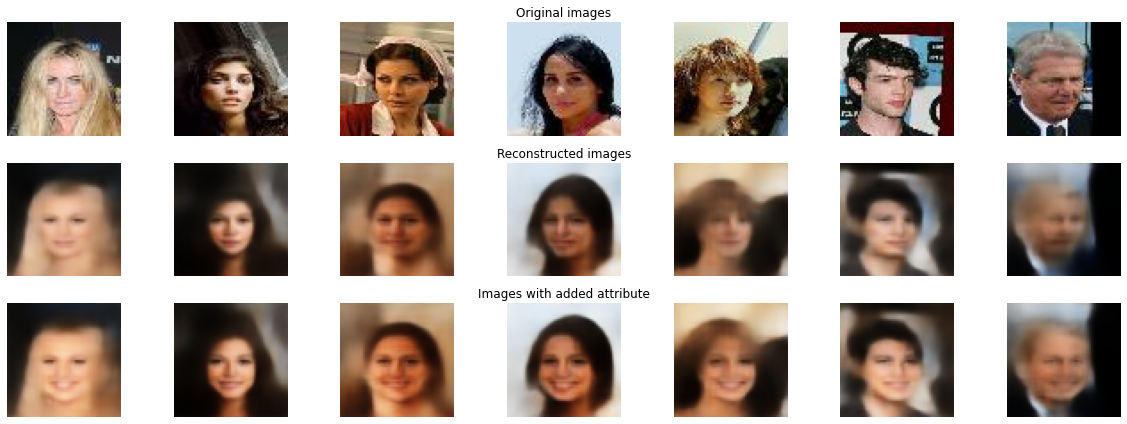

In [37]:
f, axs = plt.subplots(3, n_examples, figsize=(16, 6))
axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added attribute")
for j in range(n_examples):
    axs[0, j].imshow(sample_images_without_attribute[j])
    axs[1, j].imshow(sample_images_reconstructions[j])
    axs[2, j].imshow(modified_reconstructions[j])
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();